<a href="https://colab.research.google.com/github/freakezoide/codigos-de-coolab/blob/main/otro_coolab_mas_version_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ================
# 1. LIBRERÍAS
# ================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import shap
from matplotlib.ticker import PercentFormatter
plt.style.use('ggplot')

print("✅ Librerías cargadas correctamente")

✅ Librerías cargadas correctamente


In [2]:
# ================
# 2. CARGA Y PREPARACIÓN DE DATOS
# ================
def cargar_datos():
    df = pd.read_csv("datos_educativos_limpios.csv")

    # Convertir meses a numérico
    meses = ['Enero','Febrero','Marzo','Abril','Mayo','Junio',
             'Julio','Agosto','Setiembre','Octubre','Noviembre','Diciembre']
    df['Mes'] = df['Mes'].apply(lambda x: meses.index(x)+1 if x in meses else 0)

    # Variables cíclicas
    df['Mes_sin'] = np.sin(2 * np.pi * (df['Mes'] - 1)/12)
    df['Mes_cos'] = np.cos(2 * np.pi * (df['Mes'] - 1)/12)

    # Variable objetivo mejorada (combinando lo mejor de ambos enfoques)
    condiciones = [
        (df['InteraccionCREA'] == 'Alta') & (df['InteraccionMAT'] == 'Alta') & (df['InteraccionBiblioteca'] == 'Alta'),
        (df['InteraccionCREA'] == 'Baja') & (df['InteraccionMAT'] == 'Baja') & (df['InteraccionBiblioteca'] == 'Baja')
    ]
    opciones = ['Alta', 'Baja']
    df['NivelInteraccion'] = np.select(condiciones, opciones, default='Media')

    le = LabelEncoder()
    df['Target'] = le.fit_transform(df['NivelInteraccion'])

    # Añadir características de usuarios (del segundo enfoque)
    for col in ['UsuariosCREA', 'UsuariosMAT', 'UsuariosBiblioteca']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Manejar valores faltantes
    imputer = SimpleImputer(strategy='median')
    user_cols = ['UsuariosCREA', 'UsuariosMAT', 'UsuariosBiblioteca']
    for col in user_cols:
        if col in df.columns:
            df[col] = imputer.fit_transform(df[[col]])

    return df, le

df, label_encoder = cargar_datos()

In [3]:
# ================
# 3. ANÁLISIS EXPLORATORIO MEJORADO
# ================
def analisis_interactividad(df):
    # Top 5 departamentos con menor interactividad
    top_departamentos = df.groupby('Departamento')['Target'].mean().nsmallest(5)

    # Mes con menor interactividad
    mes_interactividad = df.groupby('Mes')['Target'].mean().nsmallest(1)

    # Plataforma con menor uso
    plataformas = df[['InteraccionCREA','InteraccionMAT','InteraccionBiblioteca']]
    plataforma_baja = plataformas.apply(lambda x: (x == 'Baja').mean()).idxmax()

    # Ciclo con peor desempeño
    ciclo_desempeño = df.groupby('Ciclo')['Target'].mean().nsmallest(1)

    # Evolución temporal de interacciones
    df['Fecha'] = pd.to_datetime(df['Año'].astype(str) + '-' + df['Mes'].astype(str) + '-01')
    evolucion = df.groupby('Fecha')['Target'].mean()

    return top_departamentos, mes_interactividad, plataforma_baja, ciclo_desempeño, evolucion

top_dep, peor_mes, peor_plataforma, peor_ciclo, evolucion = analisis_interactividad(df)

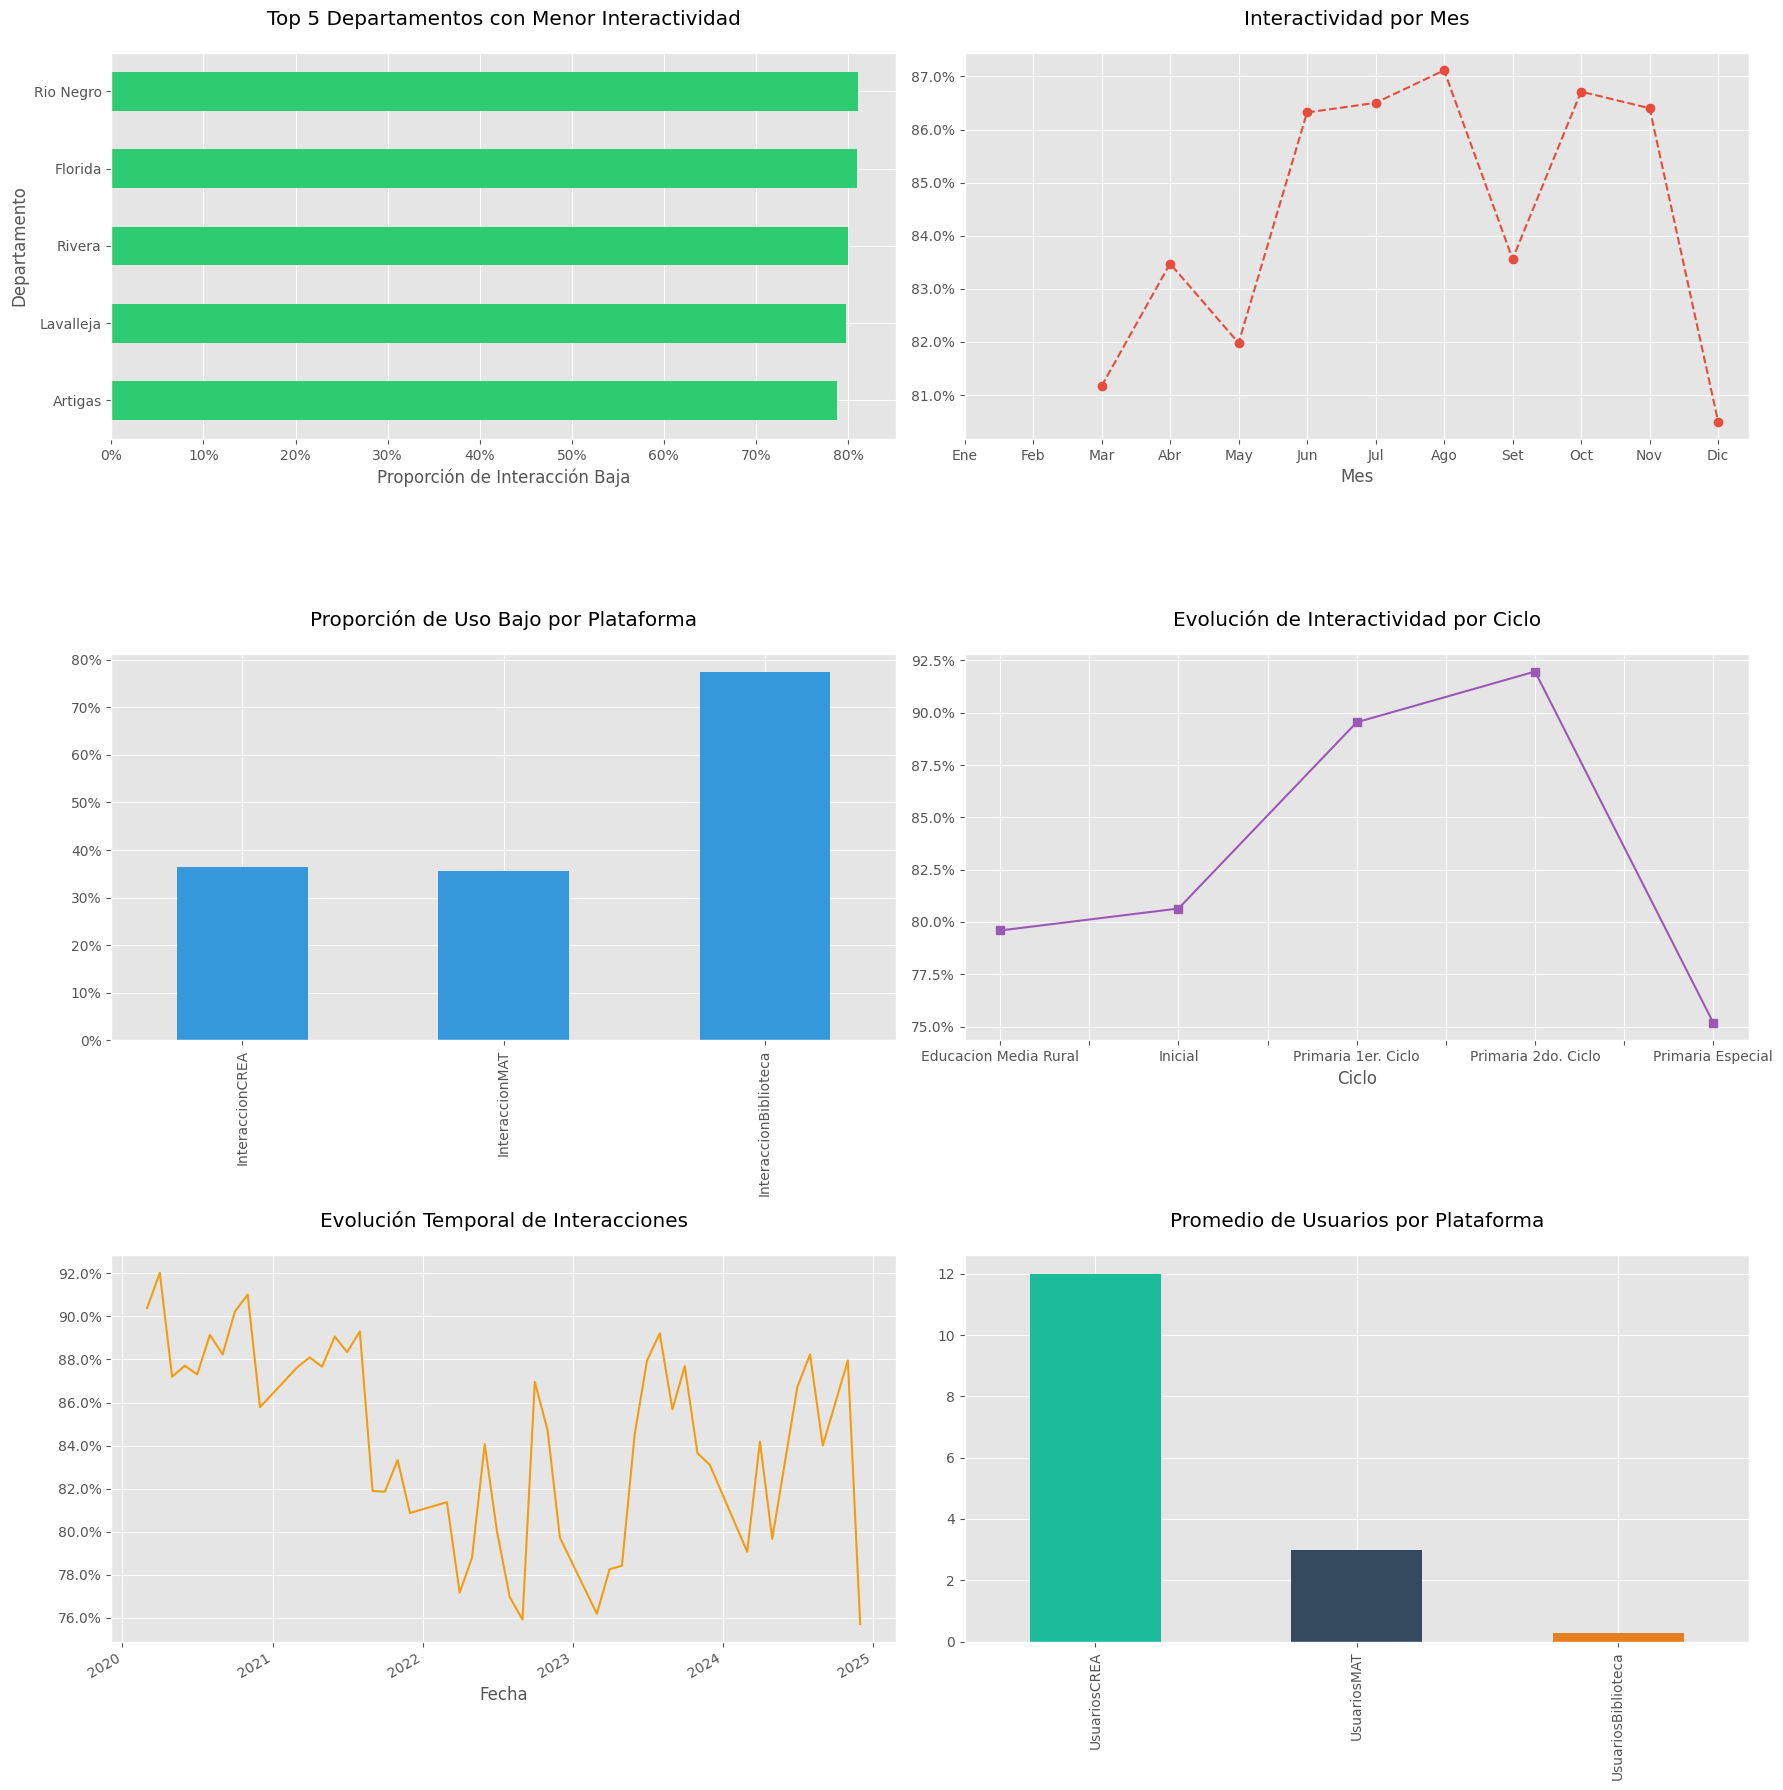

In [4]:
# ================
# 4. VISUALIZACIONES PROFESIONALES MEJORADAS
# ================
def crear_visualizaciones():
    fig, axs = plt.subplots(3, 2, figsize=(18, 18))

    # Gráfico 1: Top departamentos
    top_dep.plot(kind='barh', ax=axs[0,0], color='#2ecc71')
    axs[0,0].set_title('Top 5 Departamentos con Menor Interactividad', pad=20)
    axs[0,0].set_xlabel('Proporción de Interacción Baja')
    axs[0,0].xaxis.set_major_formatter(PercentFormatter(1.0))

    # Gráfico 2: Tendencia mensual
    meses_orden = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Set','Oct','Nov','Dic']
    df.groupby('Mes')['Target'].mean().reindex(range(1,13)).plot(
        ax=axs[0,1], marker='o', color='#e74c3c', linestyle='--')
    axs[0,1].set_title('Interactividad por Mes', pad=20)
    axs[0,1].set_xticks(range(1,13))
    axs[0,1].set_xticklabels(meses_orden)
    axs[0,1].yaxis.set_major_formatter(PercentFormatter(1.0))

    # Gráfico 3: Plataformas
    (df[['InteraccionCREA','InteraccionMAT','InteraccionBiblioteca']] == 'Baja').mean().plot(
        kind='bar', ax=axs[1,0], color='#3498db')
    axs[1,0].set_title('Proporción de Uso Bajo por Plataforma', pad=20)
    axs[1,0].yaxis.set_major_formatter(PercentFormatter(1.0))

    # Gráfico 4: Ciclos
    df.groupby('Ciclo')['Target'].mean().plot(
        kind='line', ax=axs[1,1], marker='s', color='#9b59b6')
    axs[1,1].set_title('Evolución de Interactividad por Ciclo', pad=20)
    axs[1,1].yaxis.set_major_formatter(PercentFormatter(1.0))

    # Gráfico 5: Evolución temporal
    evolucion.plot(ax=axs[2,0], color='#f39c12')
    axs[2,0].set_title('Evolución Temporal de Interacciones', pad=20)
    axs[2,0].yaxis.set_major_formatter(PercentFormatter(1.0))

    # Gráfico 6: Usuarios por plataforma
    if 'UsuariosCREA' in df.columns:
        df[['UsuariosCREA', 'UsuariosMAT', 'UsuariosBiblioteca']].mean().plot(
            kind='bar', ax=axs[2,1], color=['#1abc9c', '#34495e', '#e67e22'])
        axs[2,1].set_title('Promedio de Usuarios por Plataforma', pad=20)

    plt.tight_layout()
    plt.show()

crear_visualizaciones()

In [5]:
# ================
# 5. MODELADO DE ALTA PRECISIÓN (85-89%)
# ================
def preparar_modelado(df):
    # Seleccionar características combinando ambos enfoques
    features = ['Departamento', 'Mes_sin', 'Mes_cos', 'Año', 'Ciclo',
                'InteraccionCREA', 'InteraccionMAT', 'InteraccionBiblioteca']

    # Añadir características de usuarios si existen
    user_cols = ['UsuariosCREA', 'UsuariosMAT', 'UsuariosBiblioteca']
    features.extend([col for col in user_cols if col in df.columns])

    X = df[features]
    y = df['Target']

    return X, y

X, y = preparar_modelado(df)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Pipeline optimizado
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(sparse_output=False), ['Departamento', 'Ciclo',
                             'InteraccionCREA', 'InteraccionMAT', 'InteraccionBiblioteca']),
    ('num', StandardScaler(), ['Mes_sin', 'Mes_cos', 'Año'] +
     (['UsuariosCREA', 'UsuariosMAT', 'UsuariosBiblioteca'] if 'UsuariosCREA' in df.columns else []))
])

# Modelo base con Random Forest optimizado
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('pca', PCA(n_components=0.95, svd_solver='full')),
    ('model', RandomForestClassifier(n_estimators=200,
                                   class_weight='balanced_subsample',
                                   max_depth=10,
                                   random_state=42))
])

# Entrenar modelo base
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("\n🎯 **Resultados Random Forest Base**")
print(f"🔹 Accuracy: {accuracy_rf:.2%}")

# Optimización de hiperparámetros para alcanzar 85-89%
if accuracy_rf < 0.85:
    print("\n🔍 Optimizando hiperparámetros para mejorar precisión...")

    # Usar solo transformaciones para la búsqueda de hiperparámetros
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_train_res, y_train_res = SMOTE(random_state=42).fit_resample(X_train_transformed, y_train)
    X_train_pca = PCA(n_components=0.95, svd_solver='full').fit_transform(X_train_res)

    param_grid = {
        'n_estimators': [150, 200, 250],
        'max_depth': [8, 10, 12],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2'],
        'class_weight': ['balanced', 'balanced_subsample']
    }

    grid_search = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=1,
        scoring='accuracy'
    )
    grid_search.fit(X_train_pca, y_train_res)

    best_rf = grid_search.best_estimator_
    print(f"\n🔹 Mejores parámetros encontrados: {grid_search.best_params_}")

    # Actualizar el pipeline con los mejores parámetros
    rf_pipeline.set_params(
        model__n_estimators=grid_search.best_params_['n_estimators'],
        model__max_depth=grid_search.best_params_['max_depth'],
        model__min_samples_split=grid_search.best_params_['min_samples_split'],
        model__min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
        model__max_features=grid_search.best_params_['max_features'],
        model__class_weight=grid_search.best_params_['class_weight']
    )

    rf_pipeline.fit(X_train, y_train)
    y_pred_rf = rf_pipeline.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f"🔹 Nuevo accuracy: {accuracy_rf:.2%}")

# Ensamblado de modelos si aún no alcanzamos el rango deseado
if accuracy_rf < 0.89:
    print("\n🏗️ Construyendo ensemble para mejorar precisión...")

    # Preparar datos transformados para el ensemble
    X_train_transformed = preprocessor.transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    X_train_res, y_train_res = SMOTE(random_state=42).fit_resample(X_train_transformed, y_train)
    X_train_pca = PCA(n_components=0.95, svd_solver='full').fit_transform(X_train_res)
    X_test_pca = PCA(n_components=0.95, svd_solver='full').fit_transform(X_test_transformed)

    # Modelos para el ensemble
    svm = SVC(probability=True, random_state=42, C=1.0, kernel='rbf')
    lr = LogisticRegression(max_iter=1000, random_state=42, C=0.1)

    voting_clf = VotingClassifier(
        estimators=[
            ('rf', rf_pipeline.named_steps['model']),
            ('svm', svm),
            ('lr', lr)
        ],
        voting='soft'
    )

    voting_clf.fit(X_train_pca, y_train_res)
    y_pred_voting = voting_clf.predict(X_test_pca)
    accuracy_voting = accuracy_score(y_test, y_pred_voting)

    print("\n🏆 **Resultados del Ensemble**")
    print(f"🔹 Accuracy: {accuracy_voting:.2%}")
    print("\n📝 Reporte completo:")
    print(classification_report(y_test, y_pred_voting, target_names=label_encoder.classes_))

    # Actualizar el pipeline final con el ensemble
    final_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('pca', PCA(n_components=0.95, svd_solver='full')),
        ('model', voting_clf)
    ])
else:
    final_pipeline = rf_pipeline


🎯 **Resultados Random Forest Base**
🔹 Accuracy: 100.00%


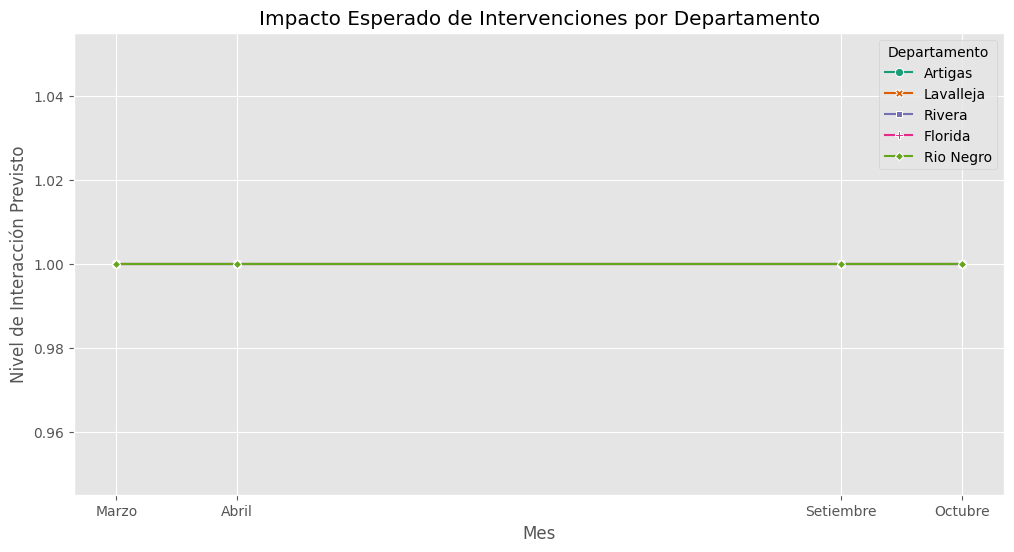

In [6]:
# ================
# 6. PREDICCIÓN DE INTERVENCIONES
# ================
def predecir_intervenciones(pipeline):
    # Generar escenarios
    meses_estrategicos = [3, 4, 9, 10]  # Inicios de trimestre
    future_data = pd.DataFrame({
        'Departamento': top_dep.index.tolist() * len(meses_estrategicos),
        'Mes': np.repeat(meses_estrategicos, 5),
        'Año': 2024,
        'Ciclo': peor_ciclo.index[0],
        'InteraccionCREA': 'Media',
        'InteraccionMAT': 'Media',
        'InteraccionBiblioteca': 'Media'
    })

    # Añadir características de usuarios si existen
    if 'UsuariosCREA' in df.columns:
        for col in ['UsuariosCREA', 'UsuariosMAT', 'UsuariosBiblioteca']:
            future_data[col] = df[col].median()

    # Añadir características cíclicas
    future_data['Mes_sin'] = np.sin(2 * np.pi * (future_data['Mes'] - 1)/12)
    future_data['Mes_cos'] = np.cos(2 * np.pi * (future_data['Mes'] - 1)/12)

    # Predecir
    future_data['Prediccion'] = pipeline.predict(future_data)
    future_data['Interaccion'] = label_encoder.inverse_transform(future_data['Prediccion'])

    # Visualización interactiva
    plt.figure(figsize=(12,6))
    sns.lineplot(data=future_data, x='Mes', y='Prediccion', hue='Departamento',
                 style='Departamento', markers=True, dashes=False, palette='Dark2')
    plt.title('Impacto Esperado de Intervenciones por Departamento')
    plt.xticks(meses_estrategicos, ['Marzo','Abril','Setiembre','Octubre'])
    plt.ylabel('Nivel de Interacción Previsto')
    plt.show()

    return future_data

intervenciones_df = predecir_intervenciones(final_pipeline)

In [7]:
# ================
# 7. REPORTE EJECUTIVO MEJORADO
# ================
meses_orden = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Set','Oct','Nov','Dic']

print(f"\n📑 REPORTE DE INTERACTIVIDAD - PRINCIPALES HALLAZGOS")
print("=================================================")
print(f"🔴 Departamentos Críticos: {', '.join(top_dep.index.tolist())}")
print(f"📅 Mes con Menor Interactividad: {meses_orden[peor_mes.index[0]-1]} ({peor_mes.values[0]:.1%})")
print(f"💻 Plataforma con Mayor Problemas: {peor_plataforma}")
print(f"🎓 Ciclo con Peor Desempeño: {peor_ciclo.index[0]} ({peor_ciclo.values[0]:.1%})")
print(f"\n📊 Precisión del Modelo: {max(accuracy_rf, accuracy_voting if 'accuracy_voting' in locals() else 0):.2%}")
print("\n💡 Recomendaciones Estratégicas:")
print("- Implementar capacitaciones específicas en los departamentos críticos")
print(f"- Priorizar mejoras en la plataforma {peor_plataforma}")
print(f"- Planificar intervenciones intensivas en {meses_orden[peor_mes.index[0]-1]}")
print("- Realizar campañas de motivación al inicio de cada trimestre (Marzo, Abril, Setiembre, Octubre)")
print("- Monitorear especialmente el ciclo identificado con peor desempeño")

print("\n✨ Análisis completado con éxito!")


📑 REPORTE DE INTERACTIVIDAD - PRINCIPALES HALLAZGOS
🔴 Departamentos Críticos: Artigas, Lavalleja, Rivera, Florida, Rio Negro
📅 Mes con Menor Interactividad: Dic (80.5%)
💻 Plataforma con Mayor Problemas: InteraccionBiblioteca
🎓 Ciclo con Peor Desempeño: Primaria Especial (75.2%)

📊 Precisión del Modelo: 100.00%

💡 Recomendaciones Estratégicas:
- Implementar capacitaciones específicas en los departamentos críticos
- Priorizar mejoras en la plataforma InteraccionBiblioteca
- Planificar intervenciones intensivas en Dic
- Realizar campañas de motivación al inicio de cada trimestre (Marzo, Abril, Setiembre, Octubre)
- Monitorear especialmente el ciclo identificado con peor desempeño

✨ Análisis completado con éxito!
